#CafChem tools using SKFingerprints

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MauricioCafiero/CafChem/blob/main/notebooks/SKFP_CafChem.ipynb)

## This notebook allows you to:
- Create a variety of 2D and 3D fingerprints using SKFingerprints
- Perform a gridsearch using the fingerprints
- Perform a fingerprints gridsearch (FP hyperparameter optimization)
- Use a variety of molecule filters from SKFingerprints
- Use several molecule distance calculations from SKFingerprints

[See the original documentation for SKFingerprints](https://scikit-fingerprints.readthedocs.io/latest/index.html)

## Requirements:

- Runs well on CPU; scales with nuymber of cores

## Install and import libraries and Cafchem

In [1]:
pip install -q scikit-fingerprints

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 482.2/482.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 20.2 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/MauricioCafiero/CafChem.git

Cloning into 'CafChem'...
remote: Enumerating objects: 1204, done.
remote: Counting objects: 100% (387/387), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 1204 (delta 361), reused 268 (delta 268), pack-reused 817 (from 2)
Receiving objects: 100% (1204/1204), 60.37 MiB | 16.40 MiB/s, done.
Resolving deltas: 100% (705/705), done.
Updating files: 100% (103/103), done.


In [3]:
from skfp.preprocessing import ConformerGenerator, MolFromSmilesTransformer
from rdkit import Chem
from rdkit.Chem import AllChem, Draw

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

from CafChem.CafChemSKFP import *

import pandas as pd
import numpy as np

<frozen importlib._bootstrap>:488: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.


## Load data from CSV

In [4]:
df = pd.read_csv('/content/905-unique-statins.csv')
df.head()

,Unnamed: 0,Ligand SMILES,IC50 (nM)
0,7,[Na+].CC(C)c1c(\C=C\[C@H](O)C[C@@H](O)CC([O-])...,0.106
1,8,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c...,0.200
2,10,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c...,0.300
3,11,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c2C...,0.300
4,12,COC(=O)C[C@H](O)C[C@H](O)\C=C\n1c(C(C)C)c(Br)c...,0.300


## Initiate FP class and create datasets

In [5]:
smiles_list, y = df['Ligand SMILES'].tolist(), df['IC50 (nM)'].tolist()

get_fp = get_fingerprints(smiles_list, y, transform_flag=True)

Welcome to the CafChem SKFP generator. The types of 2D fingerprints available are:
1. ECFP
2. Atom_Pair
3. Mordred
4. RDKit_2D
5. MACCS
6. PubChem
7. Functional_Groups
8. RDKitFingerprint
And the 3D fingerprints available are:
9. E3FP
10. Autocorr
11. MORSE
12. RDF
To create fingerprints, call the create method of this class with the FP type as the first arguement.
To perform a FP parameter gridsearch, call the get_grid method with the number of the FP as the only argument, then call fp_gridsearch with a fp type, a model, a model grid and the fp grid as arguements.


In [6]:
X_train, X_test, y_train, y_test = get_fp.create('ECFP')

Fingerprints created. The feature array size per molecule is: 2048


## Perform a model gridsearch with a chosen set of FP

In [7]:
search_grid = [
    {'n_estimators': [100, 500, 1000],
     'learning_rate': [0.01, 0.05, 0.1],
     'max_depth': [5, 10, 20]
    }
]

In [8]:
model = XGBRegressor()
search_f = GridSearchCV(estimator = model,
                       param_grid = search_grid,
                       n_jobs=-1,
                       cv=5)

search_f.fit(X_train, y_train)
print(f" Best parameters: {search_f.best_params_} and best score: {search_f.best_score_:.3f}.")

 Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500} and best score: 0.592.


In [9]:
#best_model = search_f.best_estimator_
best_model = XGBRegressor(learning_rate=0.01, max_depth=5, n_estimators=500)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R2 score: {r2:.3f}")

R2 score: 0.673


## Peform a FP gridsearch

In [8]:
get_fp = get_fingerprints(smiles_list, y, transform_flag=True)

Welcome to the CafChem SKFP generator. The types of 2D fingerprints available are:
1. ECFP
2. Atom_Pair
3. Mordred
4. RDKit_2D
5. MACCS
6. PubChem
7. Functional_Groups
8. RDKitFingerprint
And the 3D fingerprints available are:
9. E3FP
10. Autocorr
11. MORSE
12. RDF
To create fingerprints, call the create method of this class with the FP type as the first arguement.
To perform a FP parameter gridsearch, call the get_grid method with the number of the FP as the only argument, then call fp_gridsearch with a fp type, a model, a model grid and the fp grid as arguements.


In [10]:
fp_grid = get_fp.get_grid(1)
fp_grid

{'fp_size': [1024, 2048], 'radius': [2, 4, 6]}

In [12]:
rf = RandomForestRegressor()
search_grid = [
    {'n_estimators': [100, 500, 1000],
     'max_depth': [5, 10, 20]
    }
]
r2 = get_fp.fp_gridsearch('ECFP', rf, search_grid, fp_grid)

R2 score for best estimator: 0.655
Best FP parameters: {'fp_size': 2048, 'radius': 2}
CV results: [{'fp_size': 1024, 'radius': 2, 'max_depth': 20, 'n_estimators': 500, 'score': np.float64(0.5458945444412615)}, {'fp_size': 1024, 'radius': 4, 'max_depth': 20, 'n_estimators': 100, 'score': np.float64(0.5528240089875947)}, {'fp_size': 1024, 'radius': 6, 'max_depth': 20, 'n_estimators': 1000, 'score': np.float64(0.5431937434165255)}, {'fp_size': 2048, 'radius': 2, 'max_depth': 20, 'n_estimators': 500, 'score': np.float64(0.564623219818708)}, {'fp_size': 2048, 'radius': 4, 'max_depth': 20, 'n_estimators': 100, 'score': np.float64(0.5591176655389776)}, {'fp_size': 2048, 'radius': 6, 'max_depth': 20, 'n_estimators': 1000, 'score': np.float64(0.5175625095290725)}]


## Peform a 3D FP gridsearch

In [11]:
get_fp = get_fingerprints(smiles_list, y, transform_flag=True)
fp_grid = get_fp.get_grid(9)
fp_grid

Welcome to the CafChem SKFP generator. The types of 2D fingerprints available are:
1. ECFP
2. Atom_Pair
3. Mordred
4. RDKit_2D
5. MACCS
6. PubChem
7. Functional_Groups
8. RDKitFingerprint
And the 3D fingerprints available are:
9. E3FP
10. Autocorr
11. MORSE
12. RDF
To create fingerprints, call the create method of this class with the FP type as the first arguement.
To perform a FP parameter gridsearch, call the get_grid method with the number of the FP as the only argument, then call fp_gridsearch with a fp type, a model, a model grid and the fp grid as arguements.


{'fp_size': [1024, 2048], 'radius_multiplier': [1.1, 1.1718, 3.0]}

In [13]:
rf = RandomForestRegressor()
search_grid = [
    {'n_estimators': [100, 500, 1000],
     'max_depth': [5, 10, 20]
    }
]
r2 = get_fp.fp_gridsearch('E3FP', rf, search_grid, fp_grid)

R2 score for best estimator: 0.455
Best FP parameters: {'fp_size': 1024, 'radius_multiplier': 3.0}
CV results: [{'fp_size': 1024, 'radius_multiplier': 1.1, 'max_depth': 5, 'n_estimators': 100, 'score': np.float64(0.3513034559944379)}, {'fp_size': 1024, 'radius_multiplier': 1.1718, 'max_depth': 5, 'n_estimators': 100, 'score': np.float64(0.35301617689226006)}, {'fp_size': 1024, 'radius_multiplier': 3.0, 'max_depth': 20, 'n_estimators': 500, 'score': np.float64(0.4668820426339694)}, {'fp_size': 2048, 'radius_multiplier': 1.1, 'max_depth': 5, 'n_estimators': 1000, 'score': np.float64(0.35053832713986044)}, {'fp_size': 2048, 'radius_multiplier': 1.1718, 'max_depth': 5, 'n_estimators': 1000, 'score': np.float64(0.34897707626116653)}, {'fp_size': 2048, 'radius_multiplier': 3.0, 'max_depth': 20, 'n_estimators': 100, 'score': np.float64(0.46285615004464986)}]


### Test best FP

In [16]:
mols_raw = MolFromSmilesTransformer().transform(smiles_list)
mols = ConformerGenerator(num_conformers=5, optimize_force_field="UFF", n_jobs=-1).transform(mols_raw)

yt = np.log10(y)

mols_train, mols_test, y_train, y_test = scaffold_train_test_split(mols, yt, test_size=0.2)

fp = E3FPFingerprint(n_jobs=-1, fp_size=1024, radius_multiplier=3.0)
x_train = fp.transform(mols_train)
x_test = fp.transform(mols_test)

rf = RandomForestRegressor(n_estimators=500, max_depth=20)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
r2 = r2_score(y_test, y_pred)
print(f"R2 score: {r2:.3f}")

R2 score: 0.448


## Use filters

In [17]:
filters = filters(smiles_list)

Available filters include:
1. Lipinski: filters molecules that obey Lipinskis rules
2. BeyondRo5: filters molecules that obey BeyondRo5 rules
3. BMS: aims to remove molecules containing certain functional groups to filter out random noise, “promiscuous” compounds, and frequent hitters.
4. Brenk: Designed to filter out molecules containing substructures with undesirable pharmacokinetics or toxicity
5. Glaxo: Designed at Glaxo Wellcome (currently GSK) to filter out molecules with reactive functional groups, unsuitable leads (i.e. compounds which would not be initially followed up), and unsuitable natural products (i.e., derivatives of natural product compounds known to interfere with common assay procedures).
6. Pfizer: Based on observation that compounds exhibiting low partition coefficient (clogP) and high topological polar surface area (TPSA) are roughly 2.5 times more likely to be free of toxicity issues in the tested conditions
7. SureChEMBL: Based on structural alerts, i.e. toxicop

In [18]:
good_smiles = filters.get_filter('Brenk')
print(f'There are {len(good_smiles)} molecules that passed the Filter.')

There are 712 molecules that passed the Filter.


/usr/local/lib/python3.12/dist-packages/rdkit/Chem/Draw/IPythonConsole.py:343: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


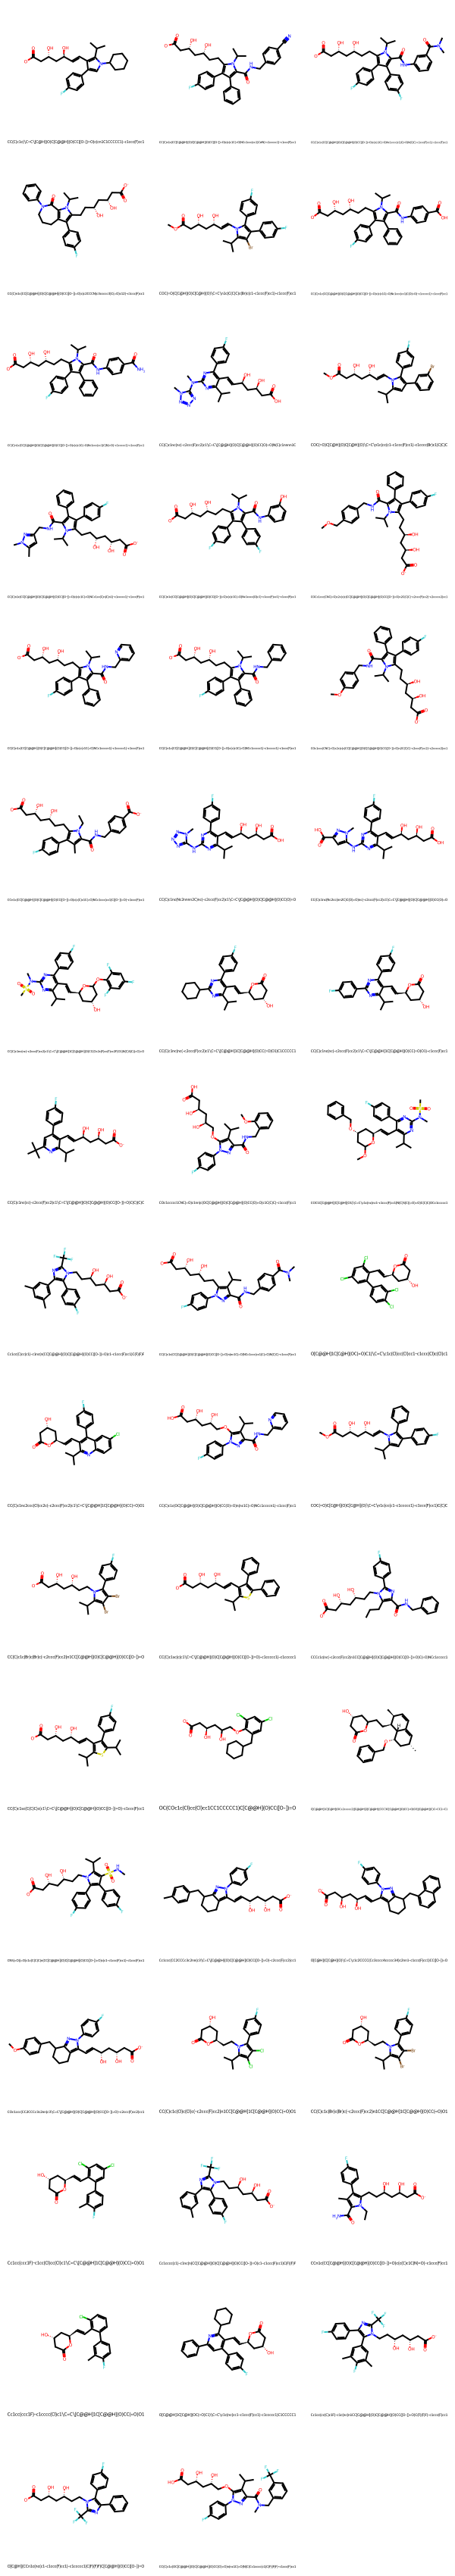

In [19]:
mols = [Chem.MolFromSmiles(smi) for smi in good_smiles]
Draw.MolsToGridImage(mols, legends = good_smiles, molsPerRow=3, subImgSize=(200,200))

## Compute distances

In [20]:
smiles_list, y = df['Ligand SMILES'].tolist(), df['IC50 (nM)'].tolist()

get_fp = get_fingerprints(smiles_list, y, transform_flag=True)

Welcome to the CafChem SKFP generator. The types of 2D fingerprints available are:
1. ECFP
2. Atom_Pair
3. Mordred
4. RDKit_2D
5. MACCS
6. PubChem
7. Functional_Groups
8. RDKitFingerprint
And the 3D fingerprints available are:
9. E3FP
10. Autocorr
11. MORSE
12. RDF
To create fingerprints, call the create method of this class with the FP type as the first arguement.
To perform a FP parameter gridsearch, call the get_grid method with the number of the FP as the only argument, then call fp_gridsearch with a fp type, a model, a model grid and the fp grid as arguements.


In [21]:
get_fp.get_distance_types()

Distance types available include:
1. Fraggle_distance
2. MCS_distance.
3. Bulk Fraggle.
4. Bulk MCS.
Call the binary_distances method with the distance type.


In [22]:
dist = get_fp.get_distances('Bulk_MCS', smiles_list[:5])
dist

array([[0.        , 0.64285714, 0.66101695, 0.6       , 0.54347826],
       [0.64285714, 0.        , 0.14285714, 0.13636364, 0.63793103],
       [0.66101695, 0.14285714, 0.        , 0.19148936, 0.6557377 ],
       [0.6       , 0.13636364, 0.19148936, 0.        , 0.59615385],
       [0.54347826, 0.63793103, 0.6557377 , 0.59615385, 0.        ]])

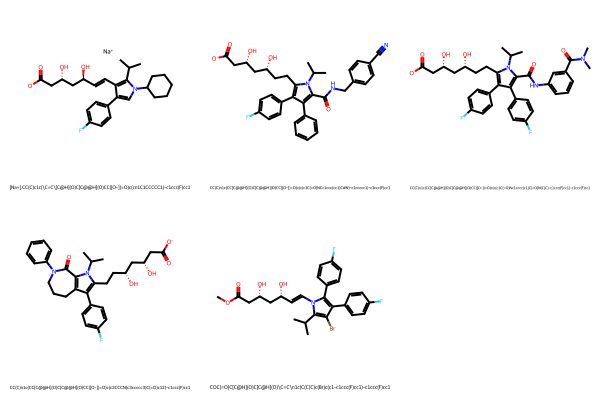

In [23]:
mols = MolFromSmilesTransformer().transform(smiles_list[:5])
Draw.MolsToGridImage(mols, legends = smiles_list[:5], molsPerRow=3, subImgSize=(200,200))

The distance between the reference and 4 is 0.18018018018018023
The distance between the reference and 8 is 0.1586826347305389
The distance between the reference and 9 is 0.2072072072072072
The distance between the reference and 17 is 0.13271604938271608
The distance between the reference and 18 is 0.14501510574018128
The distance between the reference and 24 is 0.10322580645161294
The distance between the reference and 28 is 0.2840579710144927
The distance between the reference and 33 is 0.2072072072072072
The distance between the reference and 34 is 0.23853211009174313
The distance between the reference and 35 is 0.18437499999999996
The distance between the reference and 36 is 0.25648414985590773
The distance between the reference and 37 is 0.0984126984126984
The distance between the reference and 41 is 0.2675675675675676
The distance between the reference and 42 is 0.1799410029498525
The distance between the reference and 43 is 0.20903954802259883
The distance between the reference 

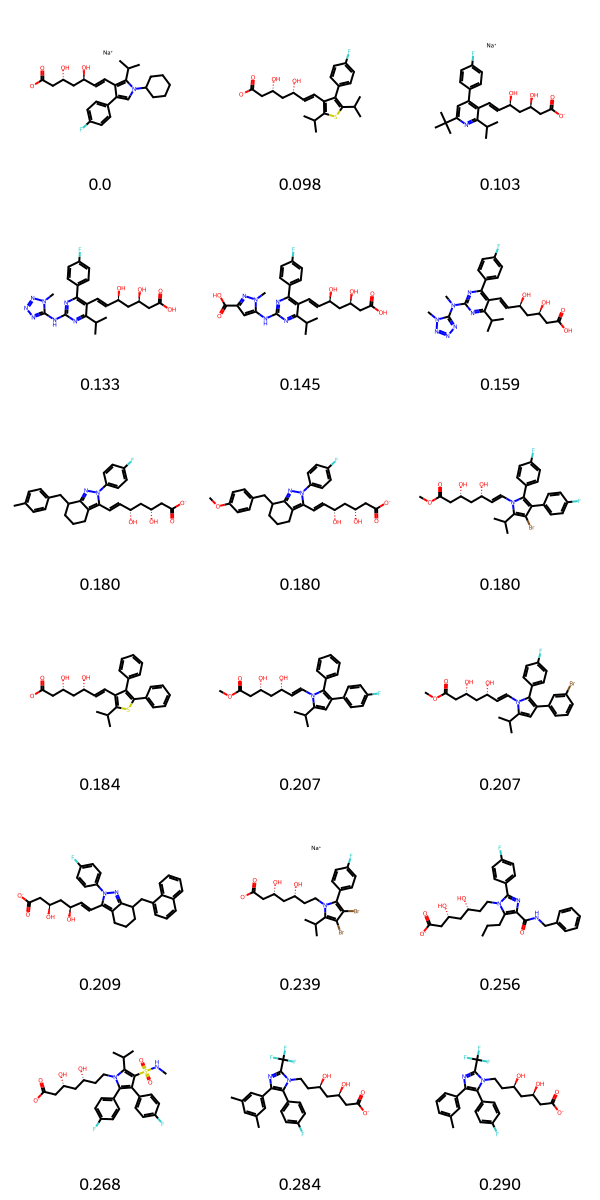

In [24]:
how_many = 50
distances = []
for i in range(1,how_many,1):
  dist = get_fp.get_distances('Fraggle_distance', [smiles_list[0],smiles_list[i]])
  distances.append(dist)

close_tuples = [(smiles_list[0],'0.0', 0.0)]
i = 1
assert(len(smiles_list[1:how_many]) == len(distances))
for smiles,distance in zip(smiles_list[1:how_many],distances):
  if distance < 0.3:
    close_tuples.append((smiles,f'{distance:.3f}', distance))
    print(f'The distance between the reference and {i} is {distance}')
  i += 1

mols_close = []
distance_close = []
distance_float = []
for smiles,distance,dist_float in close_tuples:
  mols_close.append(Chem.MolFromSmiles(smiles))
  distance_close.append(distance)
  distance_float.append(dist_float)

distance_close_sorted = [distance_close[i] for i in np.argsort(distance_float)]
mols_close_sorted = [mols_close[i] for i in np.argsort(distance_float)]

Draw.MolsToGridImage(mols_close_sorted, legends = distance_close_sorted, molsPerRow=3, subImgSize=(200,200))